In [1]:
from __future__ import division
import datetime as dt
from collections import OrderedDict
import sys, os
import dateutil.relativedelta as rd

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

gtfstk_dir = '../../gtfstk/'
sys.path.append(gtfstk_dir)
import gtfstk as gt

data_dir = gtfstk_dir + 'data/'

%load_ext autoreload
%autoreload 2
%matplotlib inline  


In [2]:
# Import a feed
feed = gt.read_gtfs(data_dir + 'cairns_gtfs.zip')

# Set study date
date = gt.compute_busiest_date(feed, gt.get_first_week(feed))
date

'20140530'

In [3]:
# Compute trips stats
trips_stats = gt.compute_trips_stats(feed)
trips_stats.head()

,trip_id,route_id,route_short_name,direction_id,shape_id,num_stops,start_time,end_time,start_stop_id,end_stop_id,is_loop,duration,distance,speed
703,CNS2014-CNS_MUL-Weekday-00-4165878,110-423,110,0,1100023,35,05:50:00,06:50:00,750337,750449,0,1.000000,32.507121,32.507121
0,CNS2014-CNS_MUL-Saturday-00-4165937,110-423,110,0,1100023,35,06:16:00,07:10:00,750337,750449,0,0.900000,32.507121,36.119024
704,CNS2014-CNS_MUL-Weekday-00-4165879,110-423,110,0,1100023,35,06:20:00,07:20:00,750337,750449,0,1.000000,32.507121,32.507121
705,CNS2014-CNS_MUL-Weekday-00-4165880,110-423,110,0,1100023,35,06:50:00,07:50:00,750337,750449,0,1.000000,32.507121,32.507121
706,CNS2014-CNS_MUL-Weekday-00-4165881,110-423,110,0,1100023,35,07:15:00,08:20:00,750337,750449,0,1.083333,32.507121,30.006574


In [4]:
# Add shape distance traveled field to stop times
feed.stop_times = gt.add_dist_to_stop_times(feed, trips_stats)
feed.stop_times.head()

,trip_id,arrival_time,departure_time,stop_id,stop_sequence,pickup_type,drop_off_type,shape_dist_traveled
17709,CNS2014-CNS_MUL-Saturday-00-4165937,06:16:00,06:16:00,750337,1,0,0,0.000000
17710,CNS2014-CNS_MUL-Saturday-00-4165937,06:16:00,06:16:00,750000,2,0,0,0.468640
17711,CNS2014-CNS_MUL-Saturday-00-4165937,06:18:00,06:18:00,750001,3,0,0,1.190380
17712,CNS2014-CNS_MUL-Saturday-00-4165937,06:20:00,06:20:00,750002,4,0,0,2.154785
17713,CNS2014-CNS_MUL-Saturday-00-4165937,06:21:00,06:21:00,750003,5,0,0,2.619003


In [5]:
# Get trips
gt.get_trips(feed, date).head()

,route_id,service_id,trip_id,trip_headsign,direction_id,block_id,shape_id
0,110-423,CNS2014-CNS_MUL-Weekday-00,CNS2014-CNS_MUL-Weekday-00-4165878,The Pier Cairns Terminus,0,NaN,1100023
1,110-423,CNS2014-CNS_MUL-Weekday-00,CNS2014-CNS_MUL-Weekday-00-4165879,The Pier Cairns Terminus,0,NaN,1100023
2,110-423,CNS2014-CNS_MUL-Weekday-00,CNS2014-CNS_MUL-Weekday-00-4165880,The Pier Cairns Terminus,0,NaN,1100023
3,110-423,CNS2014-CNS_MUL-Weekday-00,CNS2014-CNS_MUL-Weekday-00-4165881,The Pier Cairns Terminus,0,NaN,1100023
4,110-423,CNS2014-CNS_MUL-Weekday-00,CNS2014-CNS_MUL-Weekday-00-4165882,The Pier Cairns Terminus,0,NaN,1100023


In [6]:
# Compute stops stats for that date
stops_stats = gt.compute_stops_stats(feed, date, split_directions=True)
stops_stats.head()

,stop_id,direction_id,num_routes,num_trips,start_time,end_time,max_headway,min_headway,mean_headway
0,750000,0,2,34,05:50:00,27:50:00,34,23,29.863636
1,750001,0,2,34,05:52:00,27:51:00,35,23,29.909091
2,750002,0,2,34,05:54:00,27:52:00,35,23,29.909091
3,750003,0,2,34,05:55:00,27:52:00,35,23,29.909091
4,750004,0,2,34,05:57:00,27:53:00,34,23,29.863636


In [7]:
# Compute stops time series for that date
sts = gt.compute_stops_time_series(feed, date, split_directions=True)
sts = gt.downsample(sts, freq='6H')
sts.head()

indicator           num_trips                                            \
stop_id                750000 750001 750002 750003 750004 750005 750006   
direction_id                0      0      0      0      0      0      0   
2014-05-30 00:00:00         5      5      5      5      5      5      4   
2014-05-30 06:00:00        12     12     12     12     12     12     12   
2014-05-30 12:00:00        12     12     12     12     12     12     12   
2014-05-30 18:00:00         5      5      5      5      5      5      6   

indicator                                 ...                                \
stop_id             750007 750008 750009  ...   750437 750440 750448 750449   
direction_id             0      0      0  ...        0      1      0      0   
2014-05-30 00:00:00      4      4      4  ...        0      0      0      4   
2014-05-30 06:00:00     12     12     12  ...        6      5     10    110   
2014-05-30 12:00:00     12     12     12  ...        6      6      9    112   
2014-05-30 18:00:00      6      6      6  ...        4      6      2     67   

indicator                                                      
stop_id             750450 750452 750453 750454 750455 750456  
direction_id             1      1      1      1      0      1  
2014-05-30 00:00:00      5      0      5      0      0      5  
2014-05-30 06:00:00     36     28     25     11      4     46  
2014-05-30 12:00:00     44     31     33     12      6     57  
2014-05-30 18:00:00     21     22     16      5      5     22  

[4 rows x 469 columns]

In [8]:
# Compute routes stats for that date
routes_stats = gt.compute_routes_stats(feed, trips_stats, date, split_directions=True)
routes_stats.head()

,route_id,direction_id,route_short_name,num_trips,is_loop,start_time,end_time,max_headway,min_headway,mean_headway,peak_num_trips,peak_start_time,peak_end_time,service_distance,service_duration,is_bidirectional,service_speed,mean_trip_distance,mean_trip_duration
0,110-423,0,110,30,0,05:50:00,23:05:00,35,23,29.909091,3,18:13:00,18:20:00,975.213639,29.916667,1,32.597670,32.507121,0.997222
1,110-423,1,110,29,0,07:10:00,24:02:00,30,30,30.000000,2,07:40:00,08:08:00,919.009424,27.433333,1,33.499736,31.689980,0.945977
2,110N-423,0,110N,4,0,24:50:00,28:35:00,NaN,NaN,NaN,1,24:50:00,25:35:00,177.781479,3.000000,1,59.260493,44.445370,0.750000
3,110N-423,1,110N,5,0,24:40:00,29:39:00,NaN,NaN,NaN,1,24:40:00,25:39:00,221.727299,4.916667,1,45.097078,44.345460,0.983333
4,111-423,0,111,29,0,06:02:00,23:35:00,67,25,32.000000,3,06:57:00,07:05:00,1005.368216,30.366667,1,33.107625,34.667870,1.047126


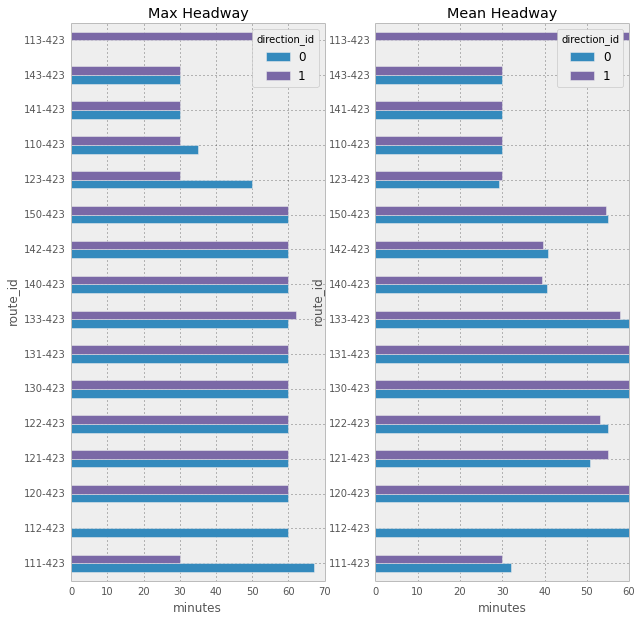

In [15]:
gt.plot_headways(routes_stats)

In [10]:
# Compute routes time series
rts = gt.compute_routes_time_series(feed, trips_stats, date, split_directions=True)
rts = gt.downsample(rts, freq='6H')
rts.head()

indicator           num_trip_starts                                      \
route_id                    110-423     110N-423    111-423     112-423   
direction_id                      0   1        0  1       0   1       0   
2014-05-30 00:00:00               1   0        4  5       0   0       0   
2014-05-30 06:00:00              12  10        0  0      12  10       5   
2014-05-30 12:00:00              12  12        0  0      12  12       6   
2014-05-30 18:00:00               5   7        0  0       5   7       4   

indicator                                 ...     service_speed             \
route_id            113-423    120-423    ...           142-423              
direction_id              0  1       0    ...                 0          1   
2014-05-30 00:00:00       0  0       1    ...               NaN        NaN   
2014-05-30 06:00:00       3  0       6    ...         25.915381  26.179643   
2014-05-30 12:00:00       0  2       6    ...         26.726927  26.179643   
2014-05-30 18:00:00       0  1       4    ...         26.726927  26.179643   

indicator                                                                  \
route_id               143-423              143W-423              150-423   
direction_id                 0          1          0         1          0   
2014-05-30 00:00:00        NaN        NaN        NaN       NaN        NaN   
2014-05-30 06:00:00  23.352055  25.496372        NaN       NaN  31.820862   
2014-05-30 12:00:00  23.352055  25.496372        NaN       NaN  31.820862   
2014-05-30 18:00:00  23.352055  25.496372  30.907527  29.87017  31.820862   

indicator                                             
route_id                         150E-423             
direction_id                 1          0          1  
2014-05-30 00:00:00        NaN        NaN        NaN  
2014-05-30 06:00:00  31.278634        NaN        NaN  
2014-05-30 12:00:00  31.278634        NaN        NaN  
2014-05-30 18:00:00  31.278634  33.833209  34.409551  

[4 rows x 200 columns]

In [11]:
f = gt.compute_feed_time_series(feed, trips_stats, date, freq='1H')
gt.downsample(f, freq='4H').head()


,num_trip_starts,service_distance,service_duration,num_trips,service_speed
2014-05-30 00:00:00,12,423.588152,8.850000,2.212500,47.863068
2014-05-30 04:00:00,81,1463.148646,49.183333,12.295833,29.748871
2014-05-30 08:00:00,164,3650.067131,128.216667,32.054167,28.467962
2014-05-30 12:00:00,162,3507.673152,123.350000,30.837500,28.436750
2014-05-30 16:00:00,149,3511.544548,119.900000,29.975000,29.287277


In [12]:
# Get trip locations for every hour of the given date
rng = pd.date_range('1/1/2000', periods=24, freq='H')
times = [t.strftime('%H:%M:%S') for t in rng]
loc = gt.compute_trips_locations(feed, date, times)
loc.head()

,trip_id,rel_dist,time,route_id,direction_id,shape_id,lon,lat
0,CNS2014-CNS_MUL-Weekday-00-4165878,0.152945,06:00:00,110-423,0,1100023,145.669490,-16.762839
1,CNS2014-CNS_MUL-Weekday-00-4165879,0.720587,07:00:00,110-423,0,1100023,145.732413,-16.865060
2,CNS2014-CNS_MUL-Weekday-00-4165880,0.152945,07:00:00,110-423,0,1100023,145.669490,-16.762839
3,CNS2014-CNS_MUL-Weekday-00-4165881,0.720587,08:00:00,110-423,0,1100023,145.732413,-16.865060
4,CNS2014-CNS_MUL-Weekday-00-4165882,0.202283,08:00:00,110-423,0,1100023,145.675422,-16.768954


In [13]:
# Get a route timetable
route = feed.routes['route_id'].iat[0]
gt.get_route_timetable(feed, route, date).head()

,route_id,service_id,trip_id,trip_headsign,direction_id,block_id,shape_id,arrival_time,departure_time,stop_id,stop_sequence,pickup_type,drop_off_type,shape_dist_traveled
0,110-423,CNS2014-CNS_MUL-Weekday-00,CNS2014-CNS_MUL-Weekday-00-4165878,The Pier Cairns Terminus,0,NaN,1100023,05:50:00,05:50:00,750337,1,0,0,0.000000
1,110-423,CNS2014-CNS_MUL-Weekday-00,CNS2014-CNS_MUL-Weekday-00-4165878,The Pier Cairns Terminus,0,NaN,1100023,05:50:00,05:50:00,750000,2,0,0,0.468640
2,110-423,CNS2014-CNS_MUL-Weekday-00,CNS2014-CNS_MUL-Weekday-00-4165878,The Pier Cairns Terminus,0,NaN,1100023,05:52:00,05:52:00,750001,3,0,0,1.190380
3,110-423,CNS2014-CNS_MUL-Weekday-00,CNS2014-CNS_MUL-Weekday-00-4165878,The Pier Cairns Terminus,0,NaN,1100023,05:54:00,05:54:00,750002,4,0,0,2.154785
4,110-423,CNS2014-CNS_MUL-Weekday-00,CNS2014-CNS_MUL-Weekday-00-4165878,The Pier Cairns Terminus,0,NaN,1100023,05:55:00,05:55:00,750003,5,0,0,2.619003


In [14]:
# Get a stop time table
stop = feed.stops['stop_id'].iat[0]
gt.get_stop_timetable(feed, stop, date).head()

,trip_id,arrival_time,departure_time,stop_id,stop_sequence,pickup_type,drop_off_type,shape_dist_traveled,route_id,service_id,trip_headsign,direction_id,block_id,shape_id
1,CNS2014-CNS_MUL-Weekday-00-4165878,05:50:00,05:50:00,750000,2,0,0,0.46864,110-423,CNS2014-CNS_MUL-Weekday-00,The Pier Cairns Terminus,0,NaN,1100023
36,CNS2014-CNS_MUL-Weekday-00-4165879,06:20:00,06:20:00,750000,2,0,0,0.46864,110-423,CNS2014-CNS_MUL-Weekday-00,The Pier Cairns Terminus,0,NaN,1100023
71,CNS2014-CNS_MUL-Weekday-00-4165880,06:50:00,06:50:00,750000,2,0,0,0.46864,110-423,CNS2014-CNS_MUL-Weekday-00,The Pier Cairns Terminus,0,NaN,1100023
106,CNS2014-CNS_MUL-Weekday-00-4165881,07:16:00,07:16:00,750000,2,0,0,0.46864,110-423,CNS2014-CNS_MUL-Weekday-00,The Pier Cairns Terminus,0,NaN,1100023
141,CNS2014-CNS_MUL-Weekday-00-4165882,07:46:00,07:46:00,750000,2,0,0,0.46864,110-423,CNS2014-CNS_MUL-Weekday-00,The Pier Cairns Terminus,0,NaN,1100023
